In [1]:
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    # HuggingFaceEmbedding
)
import json
import time 
# import HuggingFaceEmbedding
import matplotlib.pyplot as plt
from transformers.modeling_attn_mask_utils import _prepare_4d_causal_attention_mask


In [2]:
model_name = "/data/llama-hf/Llama-2-7b-hf"
# model_name = "meta-llama/Llama-2-13b-hf"
# model_name = "mistralai/Mistral-7B-v0.1"
# model_name = "Qwen/Qwen-7B"
# local_dir="/data/models"

torch.cuda.empty_cache()

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
)
device_map = {"": 0}
# Load model
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map,
    # cache_dir = local_dir,
    pad_token_id=1,
    trust_remote_code = True
)

base_model.eval()

if "Qwen" in model_name:
    tokenizer = AutoTokenizer.from_pretrained(model_name, pad_token='<|extra_0|>', trust_remote_code=True)
else:
    tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, padding_side = 'right', truncation_side='right')
# tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
# if "Llama-2" in model_name or "Mistral" in model_name:
#     # tokenizer.pad_token_id = tokenizer.bos_token_id
#     tokenizer.pad_token = tokenizer.bos_token
if tokenizer.pad_token_id == None:
    tokenizer.pad_token_id = 1

tokenizer.padding_side = "right"



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /opt/conda/envs/mytorch/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda118.so
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/targets/x86_64-linux/lib/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.6
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /opt/conda/envs/mytorch/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda118.so...


/opt/conda/envs/mytorch/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: /opt/conda/envs/mytorch did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
import datasets
from pathlib import Path
datasets.config.DOWNLOADED_DATASETS_PATH = Path("/home/ubuntu/data/.cache/huggingface")
dataset = datasets.load_dataset('c4',name = 'en', split='validation', streaming=True)

In [6]:
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)

last_token_sim = []
Ns = 100
i = 0 
for data in dataset:
    i += 1
    if i < Ns+1:
        print(i, end='\r')
        # print(data)
        ex = data['text']
    else:
        break

    tokens = tokenizer(ex, return_tensors='pt')
    input_ids = tokens.input_ids.cuda()
    # print(input_ids.shape)
    seq_length = input_ids.size(1)
    attention_mask = tokens.attention_mask.cuda()

    embed_model = base_model.model.embed_tokens
    input_embeds = embed_model(input_ids) 

    attention_mask = _prepare_4d_causal_attention_mask(
                attention_mask, (1, seq_length),
                input_embeds, 0
                )
    similarity = []
    with torch.no_grad():
        x_old = input_embeds
        for idx, block in enumerate(base_model.model.layers):
            # print(x_old.shape)
            x_new = block(x_old,attention_mask=attention_mask)[0]
            # similiarity.append(cos(x_new,x_old).cpu())
            # similarity.append(cos(x_new[:,-1,:],x_old[:,-1,:]).cpu())
            similarity.append(cos(x_new[:,-1,:].to(torch.float32),x_old[:,-1,:].to(torch.float32)).cpu())
            x_old = x_new
        x = base_model.model.norm(x_new)
        x = base_model.lm_head(x)
    # print(x.shape)
    # similiarity = torch.stack(similiarity).squeeze()
    last_token_sim.append(similarity)

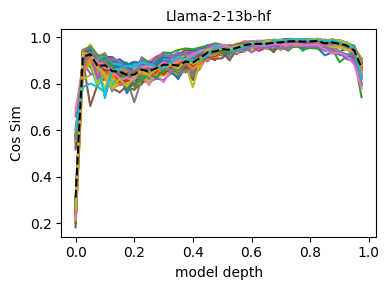

In [7]:
last_token_sim = torch.tensor(last_token_sim)
num_layers = len(base_model.model.layers)
plt.figure(figsize=(4,3))
plt.plot(torch.arange(num_layers)/num_layers, last_token_sim.T)
plt.plot(torch.arange(num_layers)/num_layers, last_token_sim.mean(dim=0),"k--")
plt.xlabel("model depth")
plt.ylabel("Cos Sim")
plt.title(f"{model_name.split('/')[-1]}", fontsize= 10)
plt.tight_layout()
# plt.savefig(f"c4_{model_name.split('/')[-1]}.png")
plt.show()

In [112]:
ex = """The woman who died after falling from a bridge over the A21 has been identified as a Sevenoaks mum. Marta Kendle, 37, fell from the Gracious Lane bridge on the morning of February 19. Police were called to the carriageway around 6.10am and the road was promptly closed in both directions. Despite paramedics best efforts, Marta, who was originally from Poland, was pronounced dead at the scene. Kent and Medway Coroners office have confirmed an inquest into her death will open on Wednesday (February 27). Tributes to the mum were left at the scene and on social media. Friend, Jodi Cahill posted on Facebook: "I will certainly remember you. I am sorry we did not see how lost and alone you felt. "Be at peace dear Marta." A floral tribute left at the scene said goodbye to the "beautiful and kind soul". It read: "To a beautiful and kind soul, we are sorry we didn&apos;t see your pain. We will miss you always. "Rest in peace Marta, Love from Lorraine, Colin and family." The inquest will take place at the Archbishop&apos;s Palace in Maidstone and will examine the circumstances surrounding Mrs Kendle&apos;s death. Are you struggling or know someone who is? Watch our video below to find out how the Samaritans could help. Mrs Kendle&apos;s death prompted the setting up of a petition calling for higher railings along the Gracious Lane bridge by Sevenoaks Common - to prevent people falling and to protect drivers from below. By today (February 25) 4,500 people had signed. The same site was the scene of another death in July last year when Southborough woman, Angela Skinner, 54, also died after falling on to the A21."""
# ex = "hello world"
# ex = "ABC is a startup based in New York City and Paris"
tokens = tokenizer(ex, return_tensors='pt')
input_ids = tokens.input_ids.cuda()
print(input_ids.shape)
seq_length = input_ids.size(1)
attention_mask = tokens.attention_mask.cuda()

embed_model = base_model.model.embed_tokens
input_embeds = embed_model(input_ids) 

attention_mask = _prepare_4d_causal_attention_mask(
            attention_mask, (1, seq_length),
            input_embeds, 0
            )
cos = torch.nn.CosineSimilarity(dim=2, eps=1e-6)
similiarity = []
activations = {}
pre_activations = {}
layer_outputs = {}
for idx in range(32):
    activations[f"{idx}"] = []
    pre_activations[f"{idx}"] = []
    layer_outputs[f"{idx}"] = []

with torch.no_grad():
    # x_old = input_embeds
    hidden_states = input_embeds
    past_key_value = None
    for idx, decoder in enumerate(base_model.model.layers):
        # hidden_states = decoder(hidden_states,attention_mask=attention_mask)[0]
        residual = hidden_states
        hidden_states = decoder.input_layernorm(hidden_states)
        hidden_states, self_attn_weights, present_key_value = decoder.self_attn(hidden_states=hidden_states,
                                                                                attention_mask=attention_mask)
        hidden_states = residual + hidden_states
        residual = hidden_states
        hidden_states = decoder.post_attention_layernorm(hidden_states)
        # hidden_states = decoder.mlp(hidden_states)
        
        pre_activations[f"{idx}"].append(decoder.mlp.gate_proj(hidden_states).to(dtype = torch.float32, device = "cpu"))
        silu_hidden_states = decoder.mlp.act_fn(decoder.mlp.gate_proj(hidden_states))
        # print(silu_hidden_states.shape)
        activations[f"{idx}"].append(silu_hidden_states.to(dtype = torch.float32, device = "cpu"))
        up_hidden_states = decoder.mlp.up_proj(hidden_states)
        hidden_states = decoder.mlp.down_proj(silu_hidden_states * up_hidden_states)

        hidden_states = residual + hidden_states
        layer_outputs[f"{idx}"].append(hidden_states.to(dtype = torch.float32, device = "cpu"))

        # # similiarity.append(cos(x_new,x_old).cpu())
        # # x_old = x_new
    hidden_states = base_model.model.norm(hidden_states)
    x = base_model.lm_head(hidden_states)
# print(x.shape)
# similiarity = torch.stack(similiarity).squeeze()
with torch.no_grad():
    y = base_model(input_ids).logits
print(torch.allclose(x.to(y),y))
# print(torch.norm(x.to(y)-y,dim=-1))


torch.Size([1, 424])
True


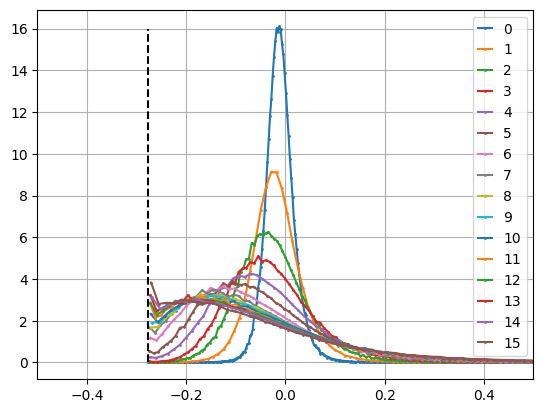

In [111]:
import numpy as np

def hist(x, num_bins, label):
    n, bin_edges = np.histogram(x, bins=num_bins)
    # n, bin_edges = np.histogram(N1, bins=num_bins)
    bins_center= (bin_edges[0:num_bins]+ bin_edges[1:])/2
    n= n/np.sum(n)/(bin_edges[1]-bin_edges[0])
    plt.plot(bins_center,n,'.-',markersize=2,label=label)
    return bins_center

for idx in range(16):
    if idx == 0:
        num_bins = 1000
    elif idx == 1:
        num_bins = 4000
    else:
        num_bins = 400
        
    x = activations[f"{idx}"][0].view(-1)
    hist(x,num_bins,f"{idx}")
plt.xlim(-0.5,0.5)
y0 = -0.278
plt.plot([y0,y0],[0,16],"k--")
plt.legend(handlelength=1)
plt.grid()

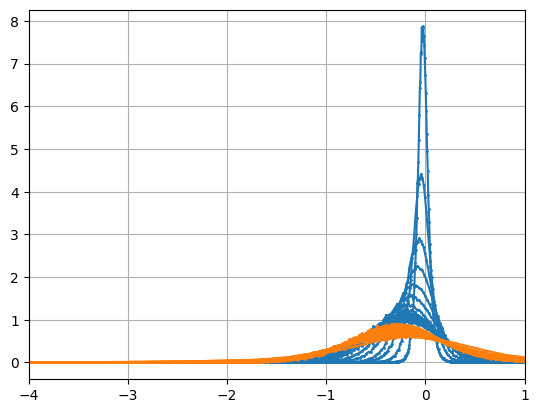

In [130]:
import numpy as np

def hist(x, num_bins, label, color = "C0"):
    n, bin_edges = np.histogram(x, bins=num_bins)
    # n, bin_edges = np.histogram(N1, bins=num_bins)
    bins_center= (bin_edges[0:num_bins]+ bin_edges[1:])/2
    n= n/np.sum(n)/(bin_edges[1]-bin_edges[0])
    # idx = np.argmax(n)
    # peak = bins_center[idx]
    peak = x.median()
    plt.plot(bins_center,n,'.-',markersize=2,color=color,label=label)
    return bins_center, peak

peak_values = []
for idx in range(0,32):
    if idx == 0:
        num_bins = 1000
    elif idx == 1:
        num_bins = 4000
    else:
        num_bins = 400
    
    x = pre_activations[f"{idx}"][0].view(-1)
    if idx< 16:    
        _, peak_val = hist(x,num_bins,f"{idx}")
    else:
        _, peak_val = hist(x,num_bins,f"{idx}","C1")
    peak_values.append(peak_val)

plt.xlim(-4,1)
# y0 = -0.278
# plt.plot([y0,y0],[0,16],"k--")
# plt.legend(handlelength=1)
plt.grid()

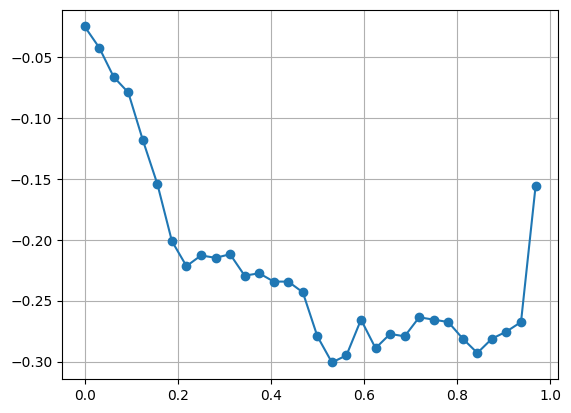

In [131]:
plt.plot(np.arange(32)/32, peak_values,"o-")
plt.grid()
plt.show()

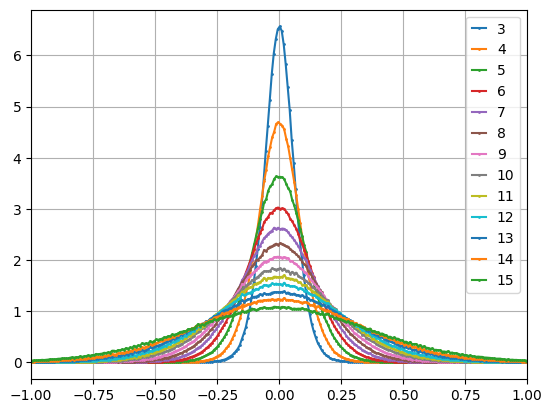

In [110]:
for idx in range(3,16):
    if idx == 0:
        num_bins = 1000
    elif idx == 1:
        num_bins = 800000
    else:
        num_bins = 500000
        
    x = layer_outputs[f"{idx}"][0].view(-1)
    hist(x,num_bins,f"{idx}")
plt.xlim(-1,1)
plt.legend(handlelength=1)
plt.grid()

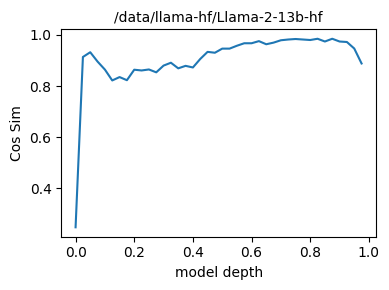

In [13]:
num_layers = len(base_model.model.layers)
plt.figure(figsize=(4,3))
plt.plot(torch.arange(num_layers)/num_layers, similiarity)
# plt.plot(torch.arange(num_layers)/num_layers, similiarity[:,1:].mean(dim=1),"k--")
plt.xlabel("model depth")
plt.ylabel("Cos Sim")
plt.title(f"{model_name}", fontsize= 10)
plt.tight_layout()
# plt.savefig(f"test_{model_name.split('/')[-1]}.png")
plt.show()

In [3]:
print(base_model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=1)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )


## parallelized

In [1]:
from torch.utils.data import DataLoader
import datasets
dataset = datasets.load_dataset('c4',name = 'en', split='validation', streaming=True)
# dataset = datasets.load_dataset('garage-bAInd/Open-Platypus', streaming=True)

def collate_fn(examples):
    prompts = [example['text'] for example in examples]
    return {'input': prompts}

BATCH_SIZE = 4
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)


In [3]:
i = 0 
for batch in data_loader:
    i += 1
    if i == 51:
        break

for text in batch['input']:
    print(len(text.split(' ')))

963
230
8925
100


In [4]:
device = "cuda"
last_token_sim = []
num_batches = 100
i = 0 
for batch in data_loader:
    i += 1
    if i < num_batches+1:
        print(i, end='\r')
        # print(batch['input'])
        # print(len(batch['input']))
    else:
        break
        
    tokens = tokenizer(batch['input'], padding=True, truncation=True, return_tensors='pt')
    input_ids = tokens.input_ids.to(device=device)
    # print(input_ids.shape)
    seq_length = input_ids.size(1)
    attention_mask = tokens.attention_mask.to(device=device)

    input_embeds = base_model.model.embed_tokens(input_ids) 

    attention_mask = _prepare_4d_causal_attention_mask(
                attention_mask, (BATCH_SIZE, seq_length),
                input_embeds, 0)
    
    input_embeds = base_model.model.embed_tokens(input_ids) 

    ### Getting the position of the last non-padding token
    ones = tokenizer.pad_token_id * torch.ones_like(input_ids)
    last_token = input_ids == ones
    row_indices = torch.arange(input_ids.size(0))
    last_token = (torch.sum(last_token, dim = 1) + 1) * (-1)


    # Extra 1 from BoS and the beginning of each string.
    if tokenizer.bos_token_id == 1:
        last_token+=1

    # print(row_indices, last_token)
    # print("Last token is", tokenizer.decode(input_ids[row_indices, last_token]))
    cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)

    similarity = []
    with torch.no_grad():
        x_old = input_embeds
        for idx, block in enumerate(base_model.model.layers):
            # print(x_old.shape)
            # print(x_new[row_indices,last_token,:].shape)
            x_new = block(x_old,attention_mask=attention_mask)[0]
            # similiarity.append(cos(x_new,x_old).cpu())
            similarity.append(cos(x_new[row_indices,last_token,:],x_old[row_indices,last_token,:]).cpu())
            x_old = x_new
        x = base_model.model.norm(x_new)
        x = base_model.lm_head(x)
    similarity = torch.stack(similarity).squeeze()
    # print("sim:", similarity.shape)
    last_token_sim.append(similarity)


last_token_sim = torch.cat(last_token_sim, dim = 1)
print("last_token_sim:", last_token_sim.shape)



Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


OutOfMemoryError: CUDA out of memory. Tried to allocate 45.73 GiB (GPU 0; 22.19 GiB total capacity; 8.31 GiB already allocated; 7.64 GiB free; 13.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

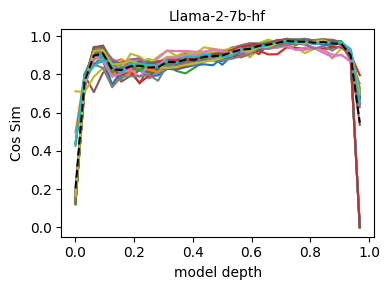

In [ ]:
num_layers = len(base_model.model.layers)
plt.figure(figsize=(4,3))
plt.plot(torch.arange(num_layers)/num_layers, last_token_sim)
plt.plot(torch.arange(num_layers)/num_layers, last_token_sim.mean(dim=1),"k--")
plt.xlabel("model depth")
plt.ylabel("Cos Sim")
plt.title(f"{model_name.split('/')[-1]}", fontsize= 10)
plt.tight_layout()
# plt.savefig(f"c4_{model_name.split('/')[-1]}.png")
plt.show()